
# Logistic-Map Symbol Dynamics (No Transient Discard) with explicit A-band `[τ_L, τ_U]`

This notebook **does not discard transients**. We start from the very first value (including \(x_0\)) and symbolization begins **at \(t=0\)**.  
We keep the explicit A-band \([\,\tau_L,\tau_U\,]\) (inclusive).

- If \(x \in [\tau_L,\tau_U]\) → **A**
- If \(x > \tau_U\) → **B**
- If \(x < \tau_L\) → **D**

We then compute the symbol sequence, transition counts/matrix, stationary distribution, spectral gap, entropy rate, and plot time-series, return map, and symbol network.



## 0. Configuration

- Set `tauL` and `tauU` so that values in `[tauL, tauU]` are labeled `A` (inclusive).
- Logistic map: parameter `r` and initial condition `x0`.
- We generate exactly `n_steps` values **including** the initial point \(x_0\).


In [ ]:

# --- Configuration: explicit A-band [tauL, tauU] ---
tauL = 0.48   # lower bound of A band (inclusive)
tauU = 0.52   # upper bound of A band (inclusive)

# Sanity: ensure tauL <= tauU and both within (0,1)
assert 0.0 < tauL <= tauU < 1.0, "Require 0 < tauL <= tauU < 1"

# --- Logistic map parameters ---
r = 3.55       # logistic parameter; try 3.5, 3.7, 3.9, 4.0 etc.
x0 = 0.51  # initial condition in (0, 1)

# --- Number of steps (NO transient discard) ---
# We will return an array of length n_steps + 1 that INCLUDES x0.
n_steps = 700



## 1. Imports


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import Tuple, Dict, Iterable



## 2. Logistic Map and Simulation (No Transient Discard)

We generate the sequence including \(x_0\):  
\[
x_0, x_1, x_2, \dots, x_{n\_steps},
\]
where \(x_{t+1} = r\,x_t(1-x_t)\).


In [ ]:

def logistic_next(x: float, r: float) -> float:
    """One step of the logistic map: x_{t+1} = r * x_t * (1 - x_t)."""
    return r * x * (1.0 - x)

def simulate_logistic_no_transient(r: float, x0: float, n_steps: int) -> np.ndarray:
    """
    Simulate the logistic map for n_steps steps, returning an array of length n_steps+1
    that INCLUDES the initial value x0: [x0, x1, ..., x_{n_steps}].
    """
    xs = np.empty(n_steps + 1, dtype=float)
    xs[0] = x0
    for t in range(n_steps):
        xs[t+1] = logistic_next(xs[t], r)
    return xs



## 3. Symbolization with Explicit A-Band \([ \tau_L, \tau_U ]\)

We assign symbols to **every** \(x_t\) starting from \(t=0\).


In [ ]:

def classify_symbol_scalar_band(x: float, tauL: float, tauU: float) -> str:
    if tauL <= x <= tauU:
        return 'A'
    elif x > tauU:
        return 'B'
    else:
        return 'D'

def classify_symbols_band(xs: np.ndarray, tauL: float, tauU: float) -> np.ndarray:
    xs = np.asarray(xs, dtype=float)
    out = np.empty(xs.shape, dtype='<U1')
    is_A = (xs >= tauL) & (xs <= tauU)
    is_B = xs > tauU
    out[is_A] = 'A'
    out[is_B] = 'B'
    out[~(is_A | is_B)] = 'D'
    return out

# Sanity checks
assert classify_symbol_scalar_band(tauL, tauL, tauU) == 'A'
assert classify_symbol_scalar_band(tauU, tauL, tauU) == 'A'
assert classify_symbol_scalar_band(np.nextafter(tauU, 1.0), tauL, tauU) == 'B'
assert classify_symbol_scalar_band(np.nextafter(tauL, 0.0), tauL, tauU) == 'D'


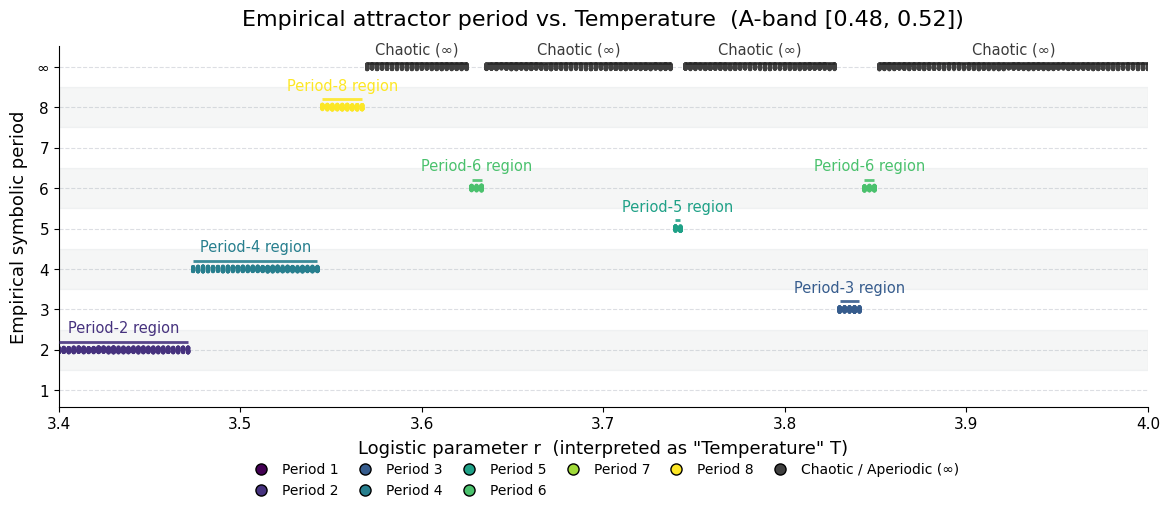

In [ ]:
# ============================================================================
# Empirical attractor period vs "Temperature" (logistic parameter r)
# - Self-contained: simulation + symbolic period detection + polished plot
# - Automatic region annotations (Period-k and Chaotic windows)
# - Only needs: numpy, matplotlib
# ============================================================================

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

# ---------------------------- CONFIG (EDIT) ---------------------------------
tauL = 0.48        # A-band lower bound (inclusive)
tauU = 0.52        # A-band upper bound (inclusive)

r_min, r_max = 3.4, 4.0   # sweep range for "temperature" (logistic r)
r_steps = 220             # resolution along r

n_inits   = 30            # runs per r (controls "fraction of runs" density)
transient = 900           # burn-in steps
window    = 240           # steps analyzed after transient
max_period = 8            # detect minimal period up to this; larger → slower

rng_seed = 7              # reproducible randomness for dynamics

# Visual knobs
marker_size   = 9
jitter_scale  = 0.12      # vertical jitter so stacked runs are visible
row_alpha     = 0.06
grid_alpha    = 0.35
dot_alpha     = 0.92
title_pad     = 15
save_path     = None      # e.g. "temp_vs_period.png" to save; or None
# ----------------------------------------------------------------------------


# ============================== Simulation ==================================
def logistic_next(x, r):
    return r * x * (1 - x)

def simulate_after_transient(r, x0, transient, window):
    x = x0
    for _ in range(transient):
        x = logistic_next(x, r)
    xs = np.empty(window, dtype=float)
    for i in range(window):
        x = logistic_next(x, r)
        xs[i] = x
    return xs

def classify_symbols_band(xs, tauL, tauU):
    xs = np.asarray(xs, dtype=float)
    out = np.empty(xs.shape, dtype='<U1')
    is_A = (xs >= tauL) & (xs <= tauU)
    is_B = xs > tauU
    out[is_A] = 'A'
    out[is_B] = 'B'
    out[~(is_A | is_B)] = 'D'
    return out

def minimal_period(symbols, max_p):
    """
    Return minimal k in [1, max_p] such that the last block of length k tiles the tail.
    If none fits, return np.inf (aperiodic for tested range).
    """
    s = ''.join(symbols.tolist())
    m = len(s)
    for k in range(1, max_p + 1):
        block = s[-k:]
        tiles = (m // k) + 2
        if (block * tiles)[-m:] == s:
            return k
    return np.inf


# ---- sweep r & collect periods ----
rng = np.random.default_rng(rng_seed)
r_values = np.linspace(r_min, r_max, r_steps)
points_r, points_period = [], []

for r in r_values:
    for _ in range(n_inits):
        x0 = rng.uniform(0.05, 0.95)
        xs = simulate_after_transient(r, x0, transient=transient, window=window)
        syms = classify_symbols_band(xs, tauL=tauL, tauU=tauU)
        p = minimal_period(syms, max_period)
        points_r.append(r)
        points_period.append(p)

points_r = np.array(points_r)
points_period = np.array(points_period)

# Map ∞ to top row index (max_period + 1)
y_levels = points_period.copy()
y_levels[np.isinf(y_levels)] = max_period + 1

# ============================== Plotting ====================================
# Clean, readable defaults
mpl.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "figure.facecolor": "white",
})

# Discrete color map by period; ∞ → neutral gray
base = mpl.colormaps['viridis'].resampled(max_period)
def color_for_period(p):
    if np.isinf(p):
        return (0.25, 0.25, 0.25, 1.0)
    idx = int(np.clip(p, 1, max_period)) - 1
    return base(idx / max(1, max_period - 1))

colors = [color_for_period(p) for p in points_period]

# Vertical jitter (separate RNG so it's stable visually)
rng_vis = np.random.default_rng(rng_seed + 123)
jitter = (rng_vis.random(size=y_levels.shape) - 0.5) * jitter_scale

fig, ax = plt.subplots(figsize=(11.8, 5.6))

# Alternating row shading & dashed grid lines
for row in range(1, max_period + 2):
    if row % 2 == 0:
        ax.axhspan(row - 0.5, row + 0.5, color="#5f6b72", alpha=row_alpha, zorder=0)
for yy in range(1, max_period + 2):
    ax.axhline(yy, linestyle='--', linewidth=0.8, color='#9ca3af', alpha=grid_alpha, zorder=0)

# Scatter points
ax.scatter(points_r, y_levels + jitter, s=marker_size, c=colors, alpha=dot_alpha, linewidths=0)

# Axes & labels
ax.set_xlim(r_min, r_max)
yticks = list(range(1, max_period + 2))
yticklabels = [str(k) for k in range(1, max_period + 1)] + ['∞']
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Logistic parameter r  (interpreted as "Temperature" T)', labelpad=6)
ax.set_ylabel('Empirical symbolic period', labelpad=6)
ax.set_title(f'Empirical attractor period vs. Temperature  (A-band [{tauL:.2f}, {tauU:.2f}])', pad=title_pad)

# ---------- Legend (below plot; no overlap) ----------
handles, labels = [], []
for k in range(1, max_period + 1):
    h = mpl.lines.Line2D([0], [0], marker='o', color='none',
                         markerfacecolor=color_for_period(k), markersize=8)
    handles.append(h); labels.append(f'Period {k}')
h_inf = mpl.lines.Line2D([0], [0], marker='o', color='none',
                         markerfacecolor=color_for_period(np.inf), markersize=8)
handles.append(h_inf); labels.append('Chaotic / Aperiodic (∞)')
ax.legend(handles, labels, ncol=6, loc='upper center',
          bbox_to_anchor=(0.5, -0.12), fontsize=10,
          columnspacing=0.9, handletextpad=0.5)

# ===================== Region annotations (auto) ======================
# Compute "mode period per r" and merge contiguous r-ranges with the same mode
mode_period_per_r = []
for rv in r_values:
    mask = np.isclose(points_r, rv)
    vals = points_period[mask]
    finite = vals[~np.isinf(vals)]
    if finite.size:
        c = Counter(finite.astype(int))
        k_mode = max(c, key=c.get)
        mode_period_per_r.append(k_mode)
    else:
        mode_period_per_r.append(np.inf)
mode_period_per_r = np.array(mode_period_per_r, dtype=float)

def contiguous_ranges(values):
    """Yield (start_index, end_index, value) for contiguous runs of the same value."""
    start = 0
    v_prev = values[0]
    for i in range(1, len(values)):
        if values[i] != v_prev:
            yield (start, i-1, v_prev)
            start = i
            v_prev = values[i]
    yield (start, len(values)-1, v_prev)

# Draw labeled spans along the top of each region
for i0, i1, v in contiguous_ranges(mode_period_per_r):
    x0, x1 = r_values[i0], r_values[i1]
    if np.isinf(v):
        label = "Chaotic (∞)"
        y_for_label = max_period + 1.25
        color = (0.15, 0.15, 0.15, 0.9)
    else:
        label = f"Period-{int(v)} region"
        y_for_label = v + 0.35
        color = color_for_period(v)

    # light bracket line above the region
    ax.hlines(y_for_label - 0.15, x0, x1, color=color, linewidth=2, alpha=0.9, zorder=3)
    # centered text
    ax.text(0.5*(x0+x1), y_for_label, label,
            ha='center', va='bottom', fontsize=10.5, color=color, zorder=4)

# Leave space for legend under the axes
fig.tight_layout(rect=[0, 0.05, 1, 1])

if save_path:
    fig.savefig(save_path, dpi=220, bbox_inches='tight')
plt.show()


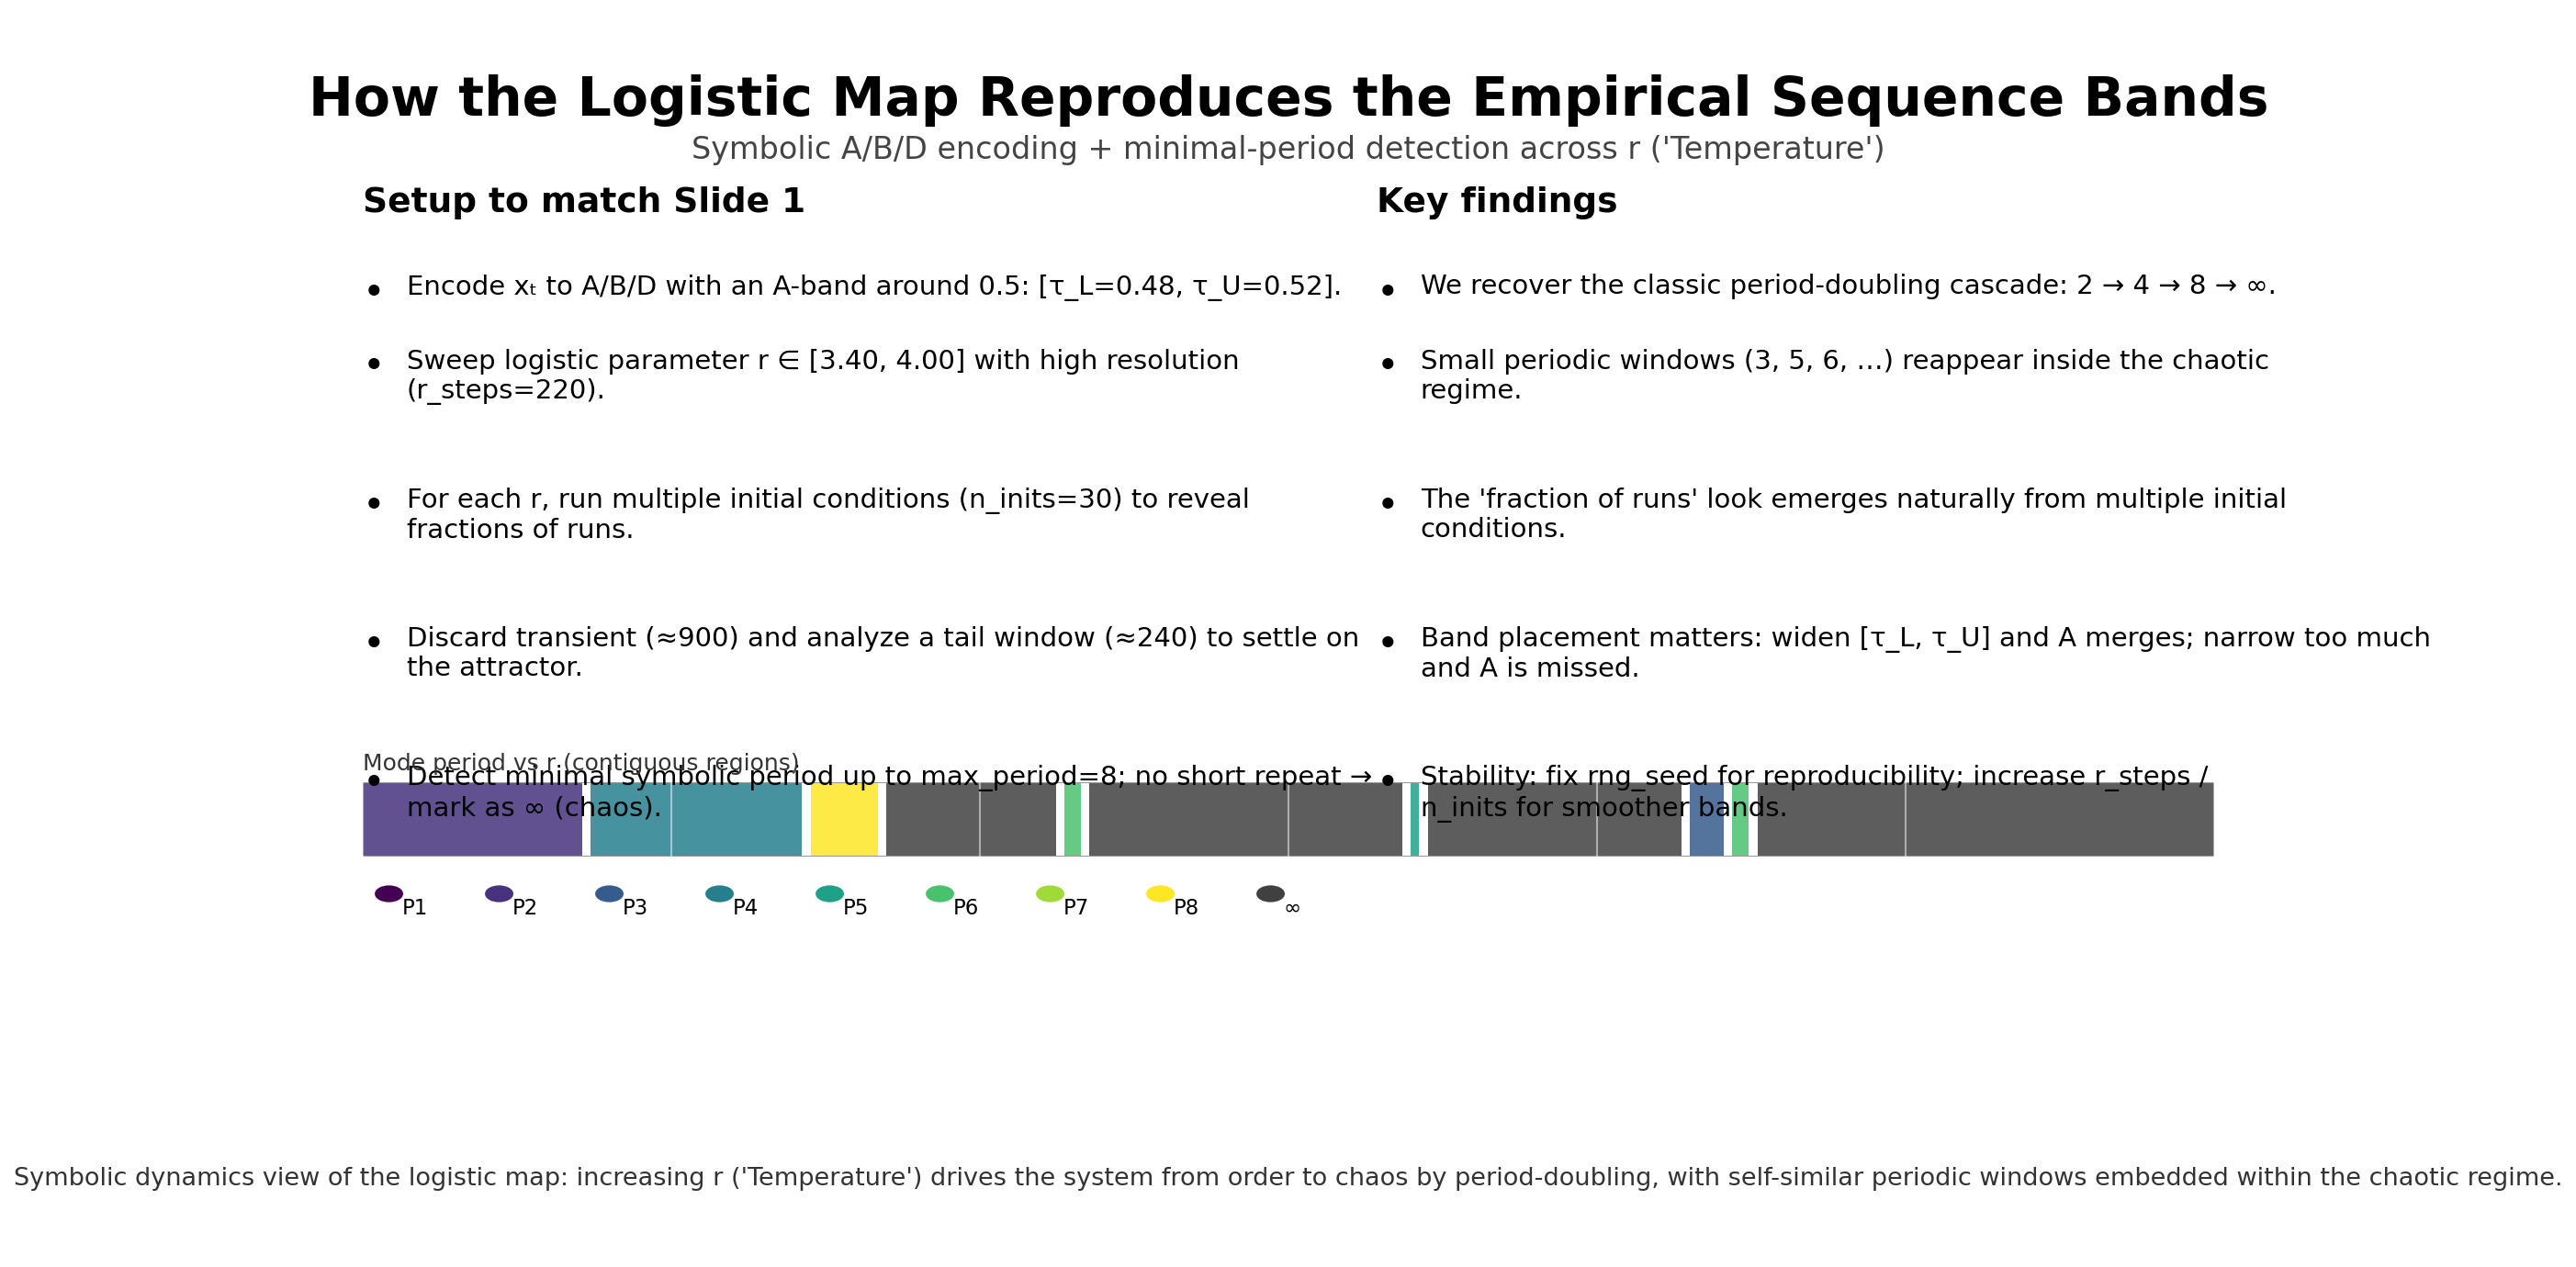

Saved Slide 2 to: slide2_findings.png


In [ ]:
# ============================================================================
# Slide 2: Findings — matching the empirical sequence plot with the logistic map
# Produces a 16:9 PNG ("slide2_findings.png") you can drop into your deck.
# Assumes you've already run Slide 1 code so tauL, tauU, r_values, points_r,
# points_period, mode_period_per_r, etc. exist. If not, it will raise a helpful error.
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from textwrap import wrap

# --- sanity: require Slide 1 artifacts ---
required = ['tauL','tauU','r_min','r_max','r_steps','n_inits','transient','window',
            'max_period','rng_seed','r_values','points_r','points_period']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Run your Slide 1 cell first. Missing variables: {missing}")

# If mode_period_per_r wasn’t kept, compute it quickly from points_*:
if 'mode_period_per_r' not in globals():
    mode_period_per_r = []
    for rv in r_values:
        mask = np.isclose(points_r, rv)
        vals = points_period[mask]
        finite = vals[~np.isinf(vals)]
        if finite.size:
            c = Counter(finite.astype(int))
            mode_period_per_r.append(max(c, key=c.get))
        else:
            mode_period_per_r.append(np.inf)
    mode_period_per_r = np.array(mode_period_per_r, dtype=float)

# ---------------- Slide text content ----------------
title   = "How the Logistic Map Reproduces the Empirical Sequence Bands"
subtitle= "Symbolic A/B/D encoding + minimal-period detection across r ('Temperature')"

left_points = [
  f"Encode xₜ to A/B/D with an A-band around 0.5: [τ_L={tauL:.2f}, τ_U={tauU:.2f}].",
  f"Sweep logistic parameter r ∈ [{r_min:.2f}, {r_max:.2f}] with high resolution (r_steps={r_steps}).",
  f"For each r, run multiple initial conditions (n_inits={n_inits}) to reveal fractions of runs.",
  f"Discard transient (≈{transient}) and analyze a tail window (≈{window}) to settle on the attractor.",
  f"Detect minimal symbolic period up to max_period={max_period}; no short repeat → mark as ∞ (chaos).",
]

right_points = [
  "We recover the classic period-doubling cascade: 2 → 4 → 8 → ∞.",
  "Small periodic windows (3, 5, 6, …) reappear inside the chaotic regime.",
  "The 'fraction of runs' look emerges naturally from multiple initial conditions.",
  "Band placement matters: widen [τ_L, τ_U] and A merges; narrow too much and A is missed.",
  "Stability: fix rng_seed for reproducibility; increase r_steps / n_inits for smoother bands.",
]

footer = ("Symbolic dynamics view of the logistic map: increasing r ('Temperature') drives the "
          "system from order to chaos by period-doubling, with self-similar periodic windows embedded "
          "within the chaotic regime.")

# ---------------- Color helper to match Slide 1 palette ----------------
import matplotlib as mpl
base = mpl.colormaps['viridis'].resampled(max_period)
def color_for_period(p):
    if np.isinf(p): return (0.25,0.25,0.25,1.0)
    idx = int(np.clip(p,1,max_period))-1
    return base(idx / max(1,max_period-1))

# ---------------- Small r-axis strip showing mode period regions -------
fig = plt.figure(figsize=(16,9), dpi=150)
ax = fig.add_axes([0,0,1,1]); ax.axis("off")

# Title & subtitle
fig.text(0.5, 0.93, title, ha='center', va='center', fontsize=28, weight='bold')
fig.text(0.5, 0.89, subtitle, ha='center', va='center', fontsize=16, color='#444')

# Left/Right headers
fig.text(0.08, 0.84, "Setup to match Slide 1", fontsize=18, weight='bold')
fig.text(0.54, 0.84, "Key findings", fontsize=18, weight='bold')

# Bullets drawer
def draw_bullets(x, y_top, bullets, width_chars=80, lh=0.052, fs=14):
    y = y_top
    for b in bullets:
        lines = wrap(b, width=width_chars)
        fig.text(x, y, u"\u2022", fontsize=fs+6, va='top')
        fig.text(x+0.02, y, "\n".join(lines), fontsize=fs, va='top')
        y -= lh * max(1, len(lines))
        y -= 0.008
    return y

draw_bullets(0.08, 0.79, left_points, width_chars=70)
draw_bullets(0.54, 0.79, right_points, width_chars=70)

# r-axis strip (mode period per r)
strip_left, strip_bottom, strip_width, strip_height = 0.08, 0.32, 0.84, 0.06
ax_strip = fig.add_axes([strip_left, strip_bottom, strip_width, strip_height])
ax_strip.set_xlim(r_min, r_max); ax_strip.set_ylim(0,1)
ax_strip.axis('off')

# Draw colored contiguous spans for each mode
def contiguous_ranges(values):
    start = 0; v_prev = values[0]
    for i in range(1, len(values)):
        if values[i] != v_prev:
            yield (start, i-1, v_prev)
            start = i; v_prev = values[i]
    yield (start, len(values)-1, v_prev)

for i0, i1, v in contiguous_ranges(mode_period_per_r):
    x0, x1 = r_values[i0], r_values[i1]
    ax_strip.fill_between([x0, x1], 0, 1, color=color_for_period(v), alpha=0.85, linewidth=0)

# Add a light frame and ticks
ax_strip.plot([r_min, r_max], [0,0], color='#999', lw=1)
ax_strip.plot([r_min, r_max], [1,1], color='#999', lw=1)
for xt in np.linspace(r_min, r_max, 7):
    ax_strip.plot([xt, xt], [0,1], color='white', alpha=0.5, lw=1)

fig.text(strip_left, strip_bottom+strip_height+0.01, "Mode period vs r (contiguous regions)", fontsize=12, color='#333')

# Minimal legend under strip
legend_labels = [f"P{k}" for k in range(1, max_period+1)] + ["∞"]
legend_colors = [color_for_period(k) for k in range(1, max_period+1)] + [color_for_period(np.inf)]
x0 = strip_left; y0 = strip_bottom - 0.03
for i,(lab,col) in enumerate(zip(legend_labels, legend_colors)):
    fig.add_artist(plt.Circle((x0 + 0.012 + i*0.05, y0), 0.006, color=col))
    fig.text(x0 + 0.018 + i*0.05, y0-0.003, lab, fontsize=11, va='top')

# Footer / caption
fig.text(0.5, 0.06, footer, ha='center', va='center', fontsize=13, color='#333')

# Save + show
out_path = "slide2_findings.png"
plt.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved Slide 2 to: {out_path}")



## 4. Run and Inspect (starting at the first symbol)


In [ ]:

xs = simulate_logistic_no_transient(r=r, x0=x0, n_steps=n_steps)
syms = classify_symbols_band(xs, tauL=tauL, tauU=tauU)

unique, counts = np.unique(syms, return_counts=True)
print("Symbol counts:", dict(zip(unique, counts)))
print("First 100 symbols:\n", ''.join(syms[:100]))


Symbol counts: {np.str_('A'): np.int64(88), np.str_('B'): np.int64(438), np.str_('D'): np.int64(175)}
First 100 symbols:
 ABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDB



## 5. Plots: Time Series and Return Map

- **Time series** now starts at \(t=0\) (includes \(x_0\)).  
- **Return map** uses pairs \((x_t, x_{t+1})\) for \(t=0,\dots,n\_steps-1\).


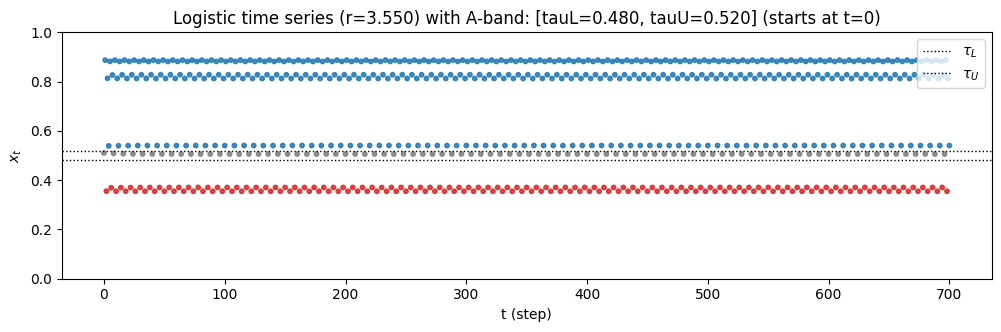

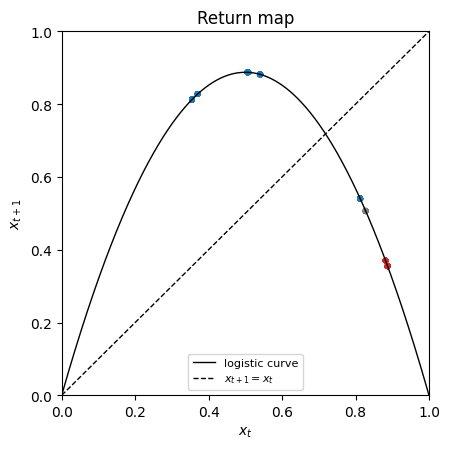

In [ ]:

COLOR = {'A':'tab:gray','B':'tab:blue','D':'tab:red'}

def plot_time_series_band(xs: np.ndarray, syms: np.ndarray, tauL: float, tauU: float):
    colors = [COLOR[s] for s in syms]
    plt.figure(figsize=(12, 3.2))
    plt.scatter(np.arange(len(xs)), xs, s=10, c=colors, alpha=0.85)
    plt.axhline(tauL, color='k', linestyle=':', linewidth=1, label=r'$\tau_L$')
    plt.axhline(tauU, color='k', linestyle=':', linewidth=1, label=r'$\tau_U$')
    plt.ylim(0, 1)
    plt.xlabel('t (step)')
    plt.ylabel(r'$x_t$')
    plt.title(f'Logistic time series (r={r:.3f}) with A-band: [tauL={tauL:.3f}, tauU={tauU:.3f}] (starts at t=0)')
    plt.legend(loc='upper right')
    plt.show()

def plot_return_map(xs: np.ndarray, syms: np.ndarray, r: float, n_sample: int = 600):
    x_t   = xs[:-1]
    x_tp1 = xs[ 1:]
    c = [COLOR[s] for s in syms[1:]]  # color by symbol of x_{t+1}
    if len(x_t) > n_sample:
        idx = np.linspace(0, len(x_t)-1, n_sample).astype(int)
        x_t, x_tp1 = x_t[idx], x_tp1[idx]
        c = [c[i] for i in idx]
    plt.figure(figsize=(4.6, 4.6))
    plt.scatter(x_t, x_tp1, s=10, c=c, alpha=0.85)
    grid = np.linspace(0, 1, 500)
    plt.plot(grid, r*grid*(1-grid), 'k-', linewidth=1, label='logistic curve')
    plt.plot(grid, grid, 'k--', linewidth=1, label=r'$x_{t+1}=x_t$')
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel(r'$x_t$'); plt.ylabel(r'$x_{t+1}$')
    plt.title('Return map')
    plt.legend(loc='lower center', fontsize=8)
    plt.tight_layout()
    plt.show()

plot_time_series_band(xs, syms, tauL, tauU)
plot_return_map(xs, syms, r)



## 6. Transitions, Markov \(P\), Stationary \(\pi\), Spectral Gap, Entropy Rate


In [ ]:

from collections import defaultdict
from typing import Dict, Tuple

def symbol_to_index_map(symbols=('A','B','D')) -> Dict[str,int]:
    return {s:i for i,s in enumerate(symbols)}

def transitions_count_and_matrix(syms: np.ndarray, symbols=('A','B','D'), eps_smooth=1e-12) -> Tuple[np.ndarray,np.ndarray]:
    s2i = symbol_to_index_map(symbols)
    K = len(symbols)
    C = np.zeros((K,K), dtype=float)
    for a,b in zip(syms[:-1], syms[1:]):
        C[s2i[a], s2i[b]] += 1.0
    row_sums = C.sum(axis=1, keepdims=True) + eps_smooth
    P = C / row_sums
    return C, P

def stationary_distribution(P: np.ndarray) -> np.ndarray:
    vals, vecs = np.linalg.eig(P.T)
    k = np.argmax(np.real(vals))
    v = np.real(vecs[:, k])
    v = np.maximum(v, 0.0)
    if v.sum() == 0:
        v = np.ones_like(v)
    return v / v.sum()

def spectral_gap(P: np.ndarray) -> float:
    vals = np.linalg.eigvals(P)
    vals = np.sort(np.abs(vals))[::-1]
    return float(max(0.0, 1.0 - (vals[1] if len(vals)>=2 else 1.0)))

def entropy_rate(P: np.ndarray, pi: np.ndarray, eps_smooth=1e-12) -> float:
    P2 = np.clip(P, eps_smooth, 1.0)
    H_rows = -(P2 * np.log2(P2)).sum(axis=1)
    return float(np.dot(pi, H_rows))

symbols_list = ('A','B','D')
C, P = transitions_count_and_matrix(syms, symbols=symbols_list)
pi = stationary_distribution(P)
gap = spectral_gap(P)
h_mu = entropy_rate(P, pi)

print("Transition counts C:\n", C)
print("Row-stochastic P (rounded):\n", np.round(P, 3))
print("Stationary distribution pi:", np.round(pi, 4))
print("Spectral gap:", round(gap, 6))
print("Entropy rate h_mu (bits/step):", round(h_mu, 6))


Transition counts C:
 [[  0.  88.   0.]
 [ 87. 175. 175.]
 [  0. 175.   0.]]
Row-stochastic P (rounded):
 [[0.    1.    0.   ]
 [0.199 0.4   0.4  ]
 [0.    1.    0.   ]]
Stationary distribution pi: [0.3333 0.3333 0.3333]
Spectral gap: 0.400458
Entropy rate h_mu (bits/step): 0.507003



## 7. Symbol Network Plot


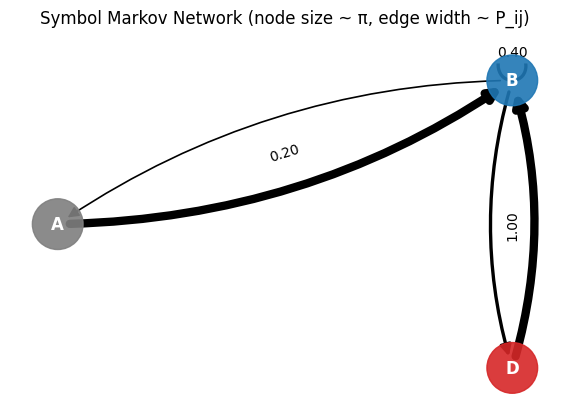

In [ ]:

COLOR = {'A':'tab:gray','B':'tab:blue','D':'tab:red'}

def plot_symbol_network(P: np.ndarray, pi: np.ndarray, symbols=('A','B','D'), min_edge=0.02):
    G = nx.DiGraph()
    for s in symbols:
        G.add_node(s)
    for i, si in enumerate(symbols):
        for j, sj in enumerate(symbols):
            if P[i,j] >= min_edge:
                G.add_edge(si, sj, weight=float(P[i,j]))
    pos = {'A':(-0.5, 0.0), 'B':(0.5, 0.4), 'D':(0.5, -0.4)}
    node_sizes = [4000 * float(pi[symbols.index(s)]) for s in symbols]
    node_colors = [COLOR[s] for s in symbols]
    plt.figure(figsize=(5.8, 4.2))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='white')
    widths = [6.0 * d['weight'] for (_,_,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=widths, arrows=True, arrowstyle='-|>', arrowsize=16, connectionstyle='arc3,rad=0.15')
    edge_labels = {(u,v): f"{P[symbols.index(u), symbols.index(v)]:.2f}" for (u,v) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title('Symbol Markov Network (node size ~ π, edge width ~ P_ij)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_symbol_network(P, pi, symbols=symbols_list, min_edge=0.02)



## 8. Optional: Quick Parameter Sweep (No Transient)

We sweep `r`, simulate from \(x_0\) with no transient discard, symbolize from the first value, and record basic stats.


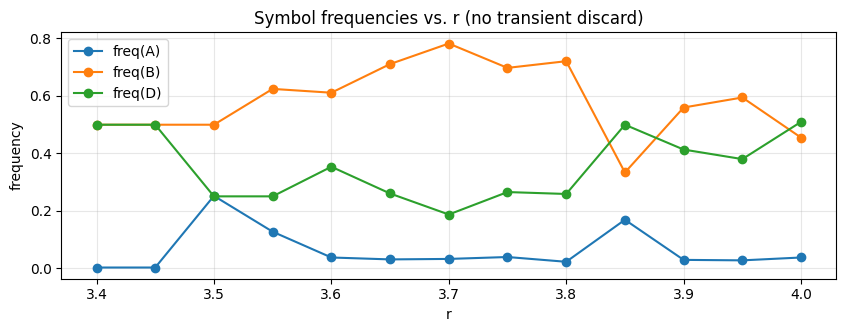

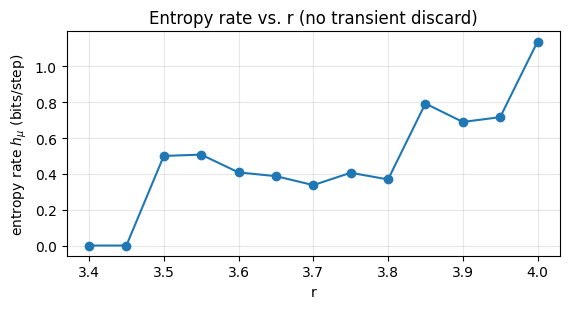

In [ ]:
def sweep_r_values_no_transient(r_values, tauL: float, tauU: float,
                                x0: float = 0.12345, n_steps: int = 600):
    rows = []
    for rv in r_values:
        xs_ = simulate_logistic_no_transient(rv, x0, n_steps=n_steps)
        syms_ = classify_symbols_band(xs_, tauL=tauL, tauU=tauU)
        C_, P_ = transitions_count_and_matrix(syms_)
        pi_ = stationary_distribution(P_)
        h_ = entropy_rate(P_, pi_)
        u, c = np.unique(syms_, return_counts=True)
        freq = {s:0.0 for s in ('A','B','D')}
        for s, cnt in zip(u, c):
            freq[s] = cnt / len(syms_)
        rows.append((rv, freq['A'], freq['B'], freq['D'], h_))
    return np.array(rows)

r_list = np.linspace(3.4, 4.0, 13)
summary = sweep_r_values_no_transient(r_list, tauL=tauL, tauU=tauU, x0=x0, n_steps=600)

plt.figure(figsize=(10,3.2))
plt.plot(summary[:,0], summary[:,1], 'o-', label='freq(A)')
plt.plot(summary[:,0], summary[:,2], 'o-', label='freq(B)')
plt.plot(summary[:,0], summary[:,3], 'o-', label='freq(D)')
plt.xlabel('r'); plt.ylabel('frequency')
plt.title('Symbol frequencies vs. r (no transient discard)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(5.8,3.2))
plt.plot(summary[:,0], summary[:,4], 'o-')
plt.xlabel('r'); plt.ylabel(r'entropy rate $h_\mu$ (bits/step)')
plt.title('Entropy rate vs. r (no transient discard)')
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
